## Vehicle Detection Project

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a Linear SVM classifier
* Apply a color transform and append binned color features, as well as histograms of color.  
(Note: Need to normalize the feature set and randomize a selection for training and testing.)
* Implement a sliding-window technique and use the trained classifier to search for vehicles in images.
* Run the pipeline on a video stream (project_video.mp4) by creating a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected using the above heat map.

In [1]:
import cv2
import glob
import numpy as np
import os
import pickle
import time
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from scipy.ndimage.measurements import label
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC, LinearSVC

from vehicle_detection_utils import *
from lane_marking_utils import *
from classes import *

# for video processing
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from collections import deque
from itertools import chain

%matplotlib inline

In [2]:
# define constants
color_space = 'YUV' # can be RGB, HSV, LUV, HLS, YUV, YCrCb
spatial_size = (32, 32) # spatial binning dimensions
hist_bins = 48    # number of histogram bins
spatial_feat = True # extract spatial features?
hist_feat = True # extract color histogram features?
hog_feat = True # extract HOG features?
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # can be 0, 1, 2, or "ALL"
y_start_stop = [400, 680] # min and max in y to search in sliding_windows() and search_windows()
window = 64 # sliding window size
scales = [1.5] # scales for sliding window

In [3]:
car_dirs = ['GTI_Far', 'GTI_Left', 'GTI_Right', 'GTI_MiddleClose', 'KITTI_extracted']
notcar_dirs = ['Extras', 'GTI', 'neg_mining']

cars, notcars = [], []
for dir in car_dirs:
    cars.extend(glob.glob(os.path.join('vehicles', dir, '*.png')))
for dir in notcar_dirs:
    notcars.extend(glob.glob(os.path.join('non-vehicles', dir, '*.png')))

print("Number of Cars: {} - Number of NotCars: {}".format(len(cars), len(notcars)))

Number of Cars: 8792 - Number of NotCars: 10714


In [4]:
# get a test image from video
image_28 = VideoFileClip('project_video.mp4').get_frame(28)

### Histogram of Oriented Gradients (HOG)

#### Explain how (and identify where in your code) you extracted HOG features from the training images.
HOG (Histograms of Oriented Gradients) is a global feature descriptor, based on image pixels' gradeints, that describes an object with a single feature vector/array. A very good explanation of HOG can be found [here](http://mccormickml.com/2013/05/09/hog-person-detector-tutorial/).  

In this project, the classifier uses the extracted HOG features to identify whether an input image is a car or not.

To see how HOGs are different in a car image and in a not-car image, we show below images:  
- a car image and its representation in YCrCb color space, a not-car image and its representation in YCrCb color space
- Per channel HOG (gradeints of cells)

The `skimage.feature.hog()` takes the image in YCrCb color space and parameters of orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), and returns gradient graph for visualization.

To achieve higher classification accuracy, a finer granularity of the parameter is chosen, i.e., orientations=9 not 8, pixels_per_cell=(8, 8) not (16, 16) and cells_per_block=(2, 2) not (3, 3).

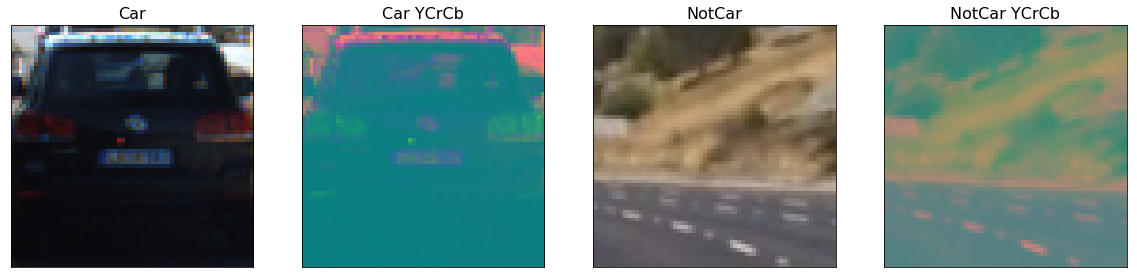

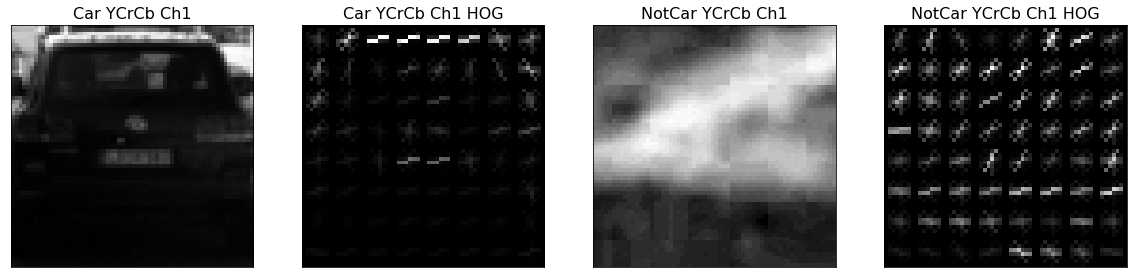

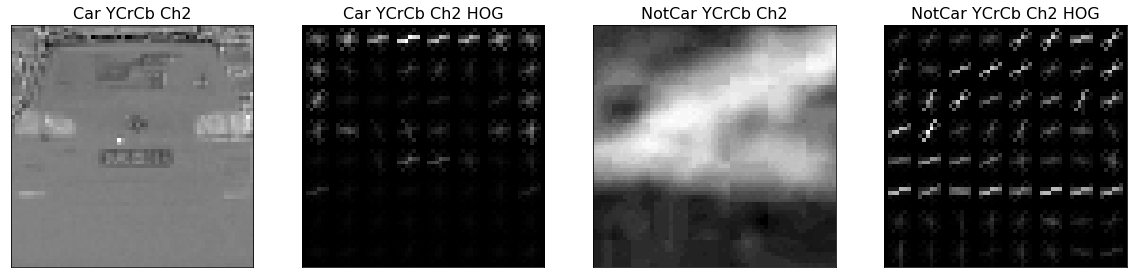

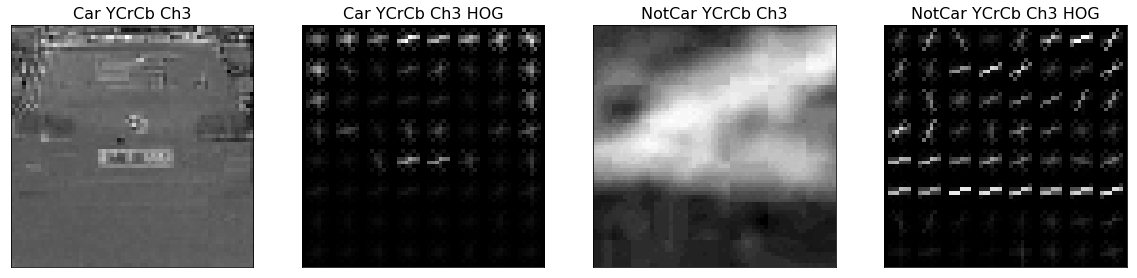

In [5]:
demo_car_notcar(cars, notcars, vis=True, feature_vec=False)

---  
In the lessons, we used `skimage.feature.hog()` to extract HOG of an image. Though the function is convenient in terms of passing parameters and getting returned values as vector/non-vector, it is quite slow and becomes an issue when applying to videos; rendering of the video `project_video.mp4` would take hours.

To see the how slow it is, let's compare run time of `skimage.feature.hog()` and `cv2.HOGDescriptor()`.  
Note: `vehicle_detection_utils.py get_hog_features_sk()` calls `skimage.feature.hog()`, `vehicle_detection_utils.py get_hog_features()` calls `cv2.HOGDescriptor()`

In [6]:
t1 = time.time()
hog_sk = get_hog_features_sk(image_28[:,:,0], orient, pix_per_cell,
                             cell_per_block, feature_vec=False)
t_sk = time.time() - t1

t2 = time.time()
hog_cv2 = get_hog_features(image_28[:,:,0], orient, pix_per_cell, 
                           cell_per_block, feature_vec=False)
t_cv2 = time.time() - t2

print("Run time for skimage.hog(): {:.3f}".format(t_sk))
print("Run time for cv2.HOGDescriptor(): {:.3f}".format(t_cv2))

Run time for skimage.hog(): 0.945
Run time for cv2.HOGDescriptor(): 0.042


We can see the run time is 20 times less in using cv2.HOGDescriptor() when processing a video frame. Thus `cv2.HOGDescriptor()` is actually used in the implementation.

### SVM Classifier

#### Describe how (and identify where in your code) you trained a classifier using your selected HOG features (and color features if you used them).

HOG features, SVM and sliding-windows are a popular combination for image detection tasks in the field of classical image processing. The combination is introduced in the lessons and used here.  

Note: Replacing SVM with a DNN (i.e., LeNet 5) slightly improves the accuracy, but the inference time is much longer and the false positve rate is high when applying to video implementation.

** Data sets **  

The training images come from a combination of the [GTI vehicle image database](http://www.gti.ssr.upm.es/data/Vehicle_database.html), the [KITTI vision benchmark suite](http://www.cvlibs.net/datasets/kitti/), and examples extracted from the project video itself.

Due to frequent false positives shown in video impelmentation, I've also added ~1700 (hard negative mining + augmented) images (`neg_mining.tar.gz`) to reduce the false positve rate.

** Features Extraction **  

In addition to HOG features, I also added spatial features and color-histograms features with `spatial_size=32` and `hist_bins=48` to achieve higher classification accuracy. Compared to RGB, HSV and HSL, YCrCb color space yields a higher accuracy. YUV color space achieves a comparable accuracy, therefore YUV can also be used.  

These are functions used to extract features ( in `vehicle_detection_utils.py`):
- `get_hog_features()`: extrat HOG features
- `get_spatial_features()`: extract spatial features
- `get_colorhist_features()`: extract color-histograms features

** The Classifier **  

`LinearSVC` is chosen as the classifier.  

`LinearSVC` and `svm.SVC` with linear kernel are both linear support vector machine, but the former run much faster. `svm.SVC` has "The fit time complexity is more than quadratic with the number of samples" per sklearn documentation, that makes training with `svm.SVC` way much slower.  

As the accuracy is 99.2+%, I did not tune the hyperparameters C and gamma but use the default values.

Below cells are the steps of extracting features, normalize the data, randomdly spliting training and test sets, training the model, and finally run trained model on test set.  

The mis-classified test images are also shown. We can see those images are not likely seen in the video clips, so I think I would leave it for now. To make the model to be more robust, we can apply data augmentation specifically to those images.

#### 1. Extract car and notcar features

In [7]:
car_features, notcar_features = [], []
t1 = time.time()
for car in cars:
    img = cv2.imread(car)
    img = convert_cspace(img, cvt_from='BGR', cvt_to=color_space)
    features = extract_features(img, 
                                spatial_size=spatial_size,
                                hist_bins=hist_bins,
                                orient=orient, 
                                pix_per_cell=pix_per_cell, 
                                cell_per_block=cell_per_block, 
                                hog_channel=hog_channel,
                                spatial_feat=spatial_feat,
                                hist_feat=hist_feat,
                                hog_feat=hog_feat)
    car_features.append(features)
for notcar in notcars:
    img = cv2.imread(notcar)
    img = convert_cspace(img, cvt_from='BGR', cvt_to=color_space)
    features = extract_features(img, 
                                spatial_size=spatial_size,
                                hist_bins=hist_bins,
                                orient=orient, 
                                pix_per_cell=pix_per_cell, 
                                cell_per_block=cell_per_block, 
                                hog_channel=hog_channel,
                                spatial_feat=spatial_feat,
                                hist_feat=hist_feat,
                                hog_feat=hog_feat,
                                feature_vec=True)
    notcar_features.append(features)
    
print("car_features.shape:{}, notcar_features.shape:{}".format(
                    np.array(car_features).shape, np.array(notcar_features).shape))
print("Time elapsed Extract features: {}s".format(time.time()-t1))

car_features.shape:(8792, 8508), notcar_features.shape:(10714, 8508)
Time elapsed Extract features: 37.591673135757446s


#### 2. Prepare training, test sets

In [8]:
X = np.concatenate((car_features, notcar_features)).astype(np.float32)
y = np.concatenate((np.ones(len(car_features)), np.zeros(len(notcar_features)))) 

In [9]:
indices = np.arange(len(y))
X_train, X_test, y_train, y_test, inds_train, inds_test = train_test_split(
                                X, y, indices, test_size=0.2, random_state=42)
print("X_train, y_train: {}".format((X_train.shape, y_train.shape)))
print("X_test, y_test: {}".format((X_test.shape, y_test.shape)))

X_train, y_train: ((15604, 8508), (15604,))
X_test, y_test: ((3902, 8508), (3902,))


#### 3. Train the model and run on test set

In [10]:
model_path = 'lsvc_ycrcb.p'

if os.path.isfile(model_path):
    pkl = pickle.load(open(model_path, 'rb'))
    lsvc = pkl['lsvc']
    scaler = pkl['scaler']
else:
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    lsvc = LinearSVC()
    lsvc.fit(X_train_scaled, y_train)
    
    train_accuracy = lsvc.score(X_train_scaled, y_train)
    test_accuracy = lsvc.score(X_test_scaled, y_test)
    print("train_accuracy: {} - test_accuracy: {}".format(train_accuracy, test_accuracy))

train_accuracy: 1.0 - test_accuracy: 0.9923116350589442


In [11]:
%%script false
d = {'lsvc': lsvc,
     'scaler': scaler}
pickle.dump(d, open(model_path, 'wb'))

#### 4. What are those misclassifed images?

In [12]:
test_pred = lsvc.predict(X_test_scaled)
incorrect = np.where(test_pred != y_test)[0]

incorrect number: 30
error rate: 0.007688364941055869


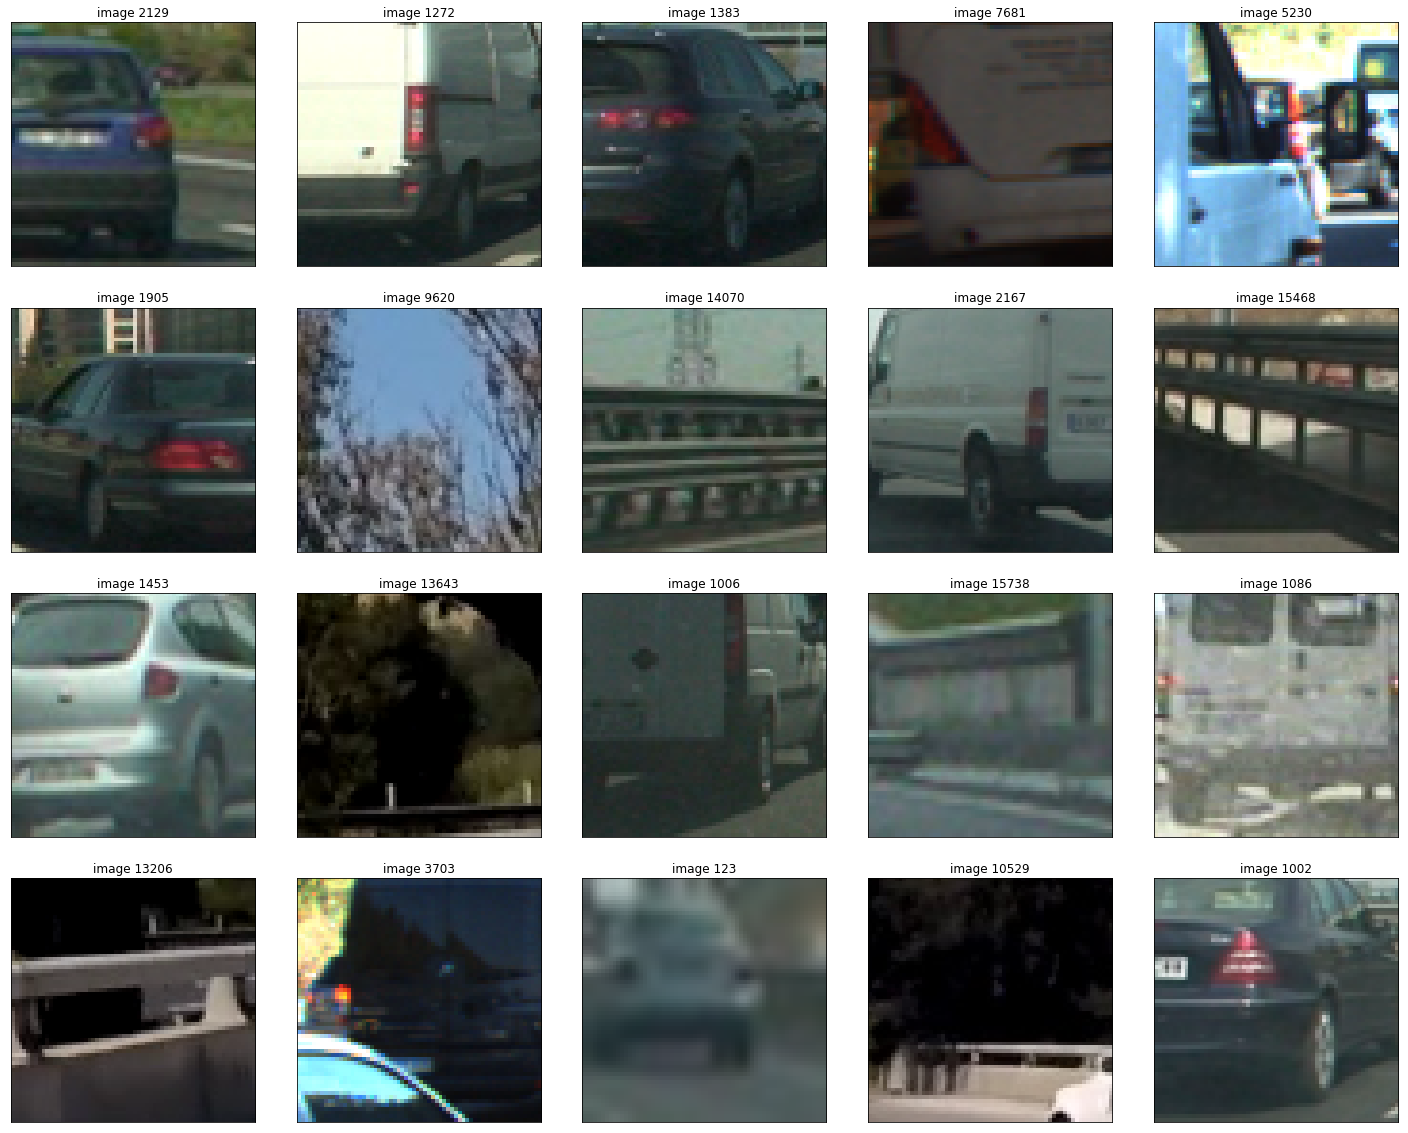

In [13]:
print("incorrect number: {}".format(len(incorrect)))
print("error rate: {}".format(len(incorrect) / len(y_test)))

inds_incorr = inds_test[incorrect]

all = cars + notcars
fig, axes = plt.subplots(4, 5, figsize=(20, 16))
plt.tight_layout()
for i, ax in zip(inds_incorr, axes.flatten()):
    im = mpimg.imread(all[i])
    ax.set_title("image " + str(i))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(im)

### Sliding Window Search

#### 1. Describe how (and identify where in your code) you implemented a sliding window search.  How did you decide what scales to search and how much to overlap windows?

To systematically survey regions of an image, we use window(s) to slide through x- and y- directions. The collection of slided regions (image patches) are fed to the trained SVM classifier to be determined whether a region is a car or not.  

The parameters are:
- window size (x and y)
- overlap per step (x and y)
- region to search for  

In the actual implementation, instead of using different window size, we have a fixed `window=64` and use `scale` to scale the image, which equivalently changes the window size. Also, instead of specifying overlap percentage per slide, number of cells per step is used. This is necessary for one-shot HOG feature extraction because 'cell' is the smallest unit in HOG descriptor, we won't be able to access the gradients that does not start at some cell's boundary.

Here is an example shows windows from `sliding_windows()` in `vehicle_detection_utils.py`, with scales = 1.5 and 2, number of cell per step = 2. We also limit our search below the horizon and exclude the bottom portion of the image where no car would appear (y = 380~680).

Number of windows:  2585


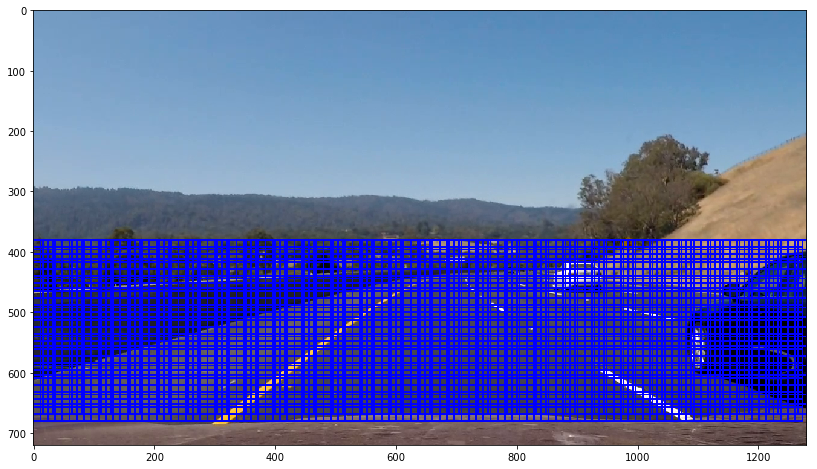

In [14]:
windows = sliding_windows(image_28, scales=[1.5, 2.], y_start_stop=[380, 680])
draw_img = draw_boxes(image_28, windows, thick=2)
plt.figure(figsize=(20, 8))
print("Number of windows: ", len(windows))
plt.imshow(draw_img)

I decided to use single scale = 1.5 and cells per step = one cell.  

Adding scale=1 results more accurate bounding box but also dramatically increases per frame processing time. Adding scale=2 stablelizes the bounding boxes slightly but again slow down the video processing (though it's still acceptable). On the other hand, using single scale=1.5 is good enough to approximately cover the two cars of all sizes, near and far.  

And the number of cells per step has to be one to be able to create resonably tight and stable bounding boxes.  
Below is the windows returned from `sliding_windows()` with `scale=[1.5]` and `cells_per_step=1`.

Number of windows:  1782


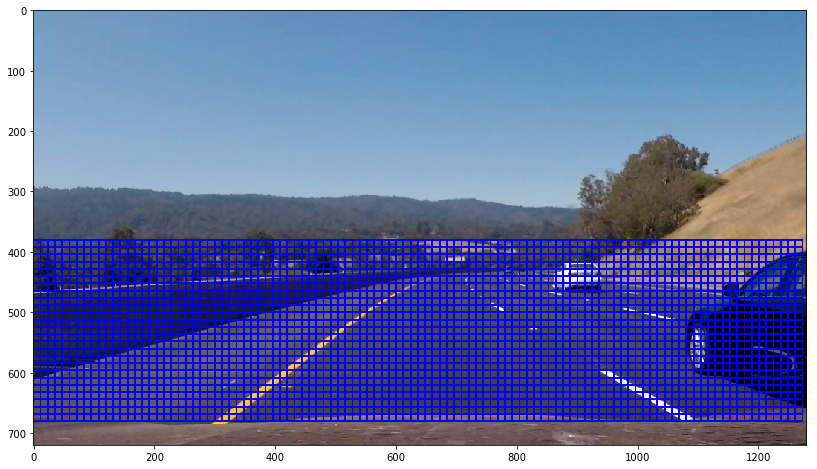

In [15]:
windows_15 = sliding_windows(image_28, scales=[1.5], y_start_stop=[380, 680])
draw_img = draw_boxes(image_28, windows_15, thick=2)
plt.figure(figsize=(20, 8))
print("Number of windows: ", len(windows_15))
plt.imshow(draw_img)

#### 2. Show some examples of test images to demonstrate how your pipeline is working.  What did you do to optimize the performance of your classifier?

Ultimately I searched on one scale(=1.5) using YCrCb 3-channel HOG features plus spatially binned color and histograms of color in the feature vector, which provided a nice result.  
To make the feature extraction efficient, I used one-shot HOG extraction on the whole image and then get the sub-images HOG features by slicing from the HOG features of the whole image.  

Here are some example images:

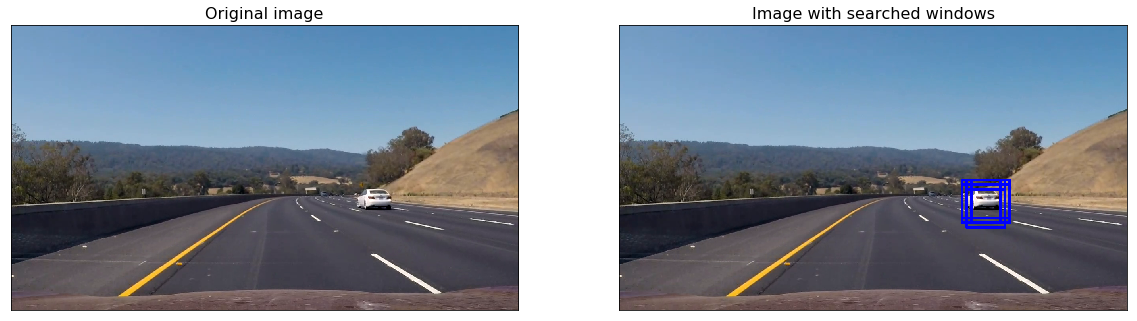

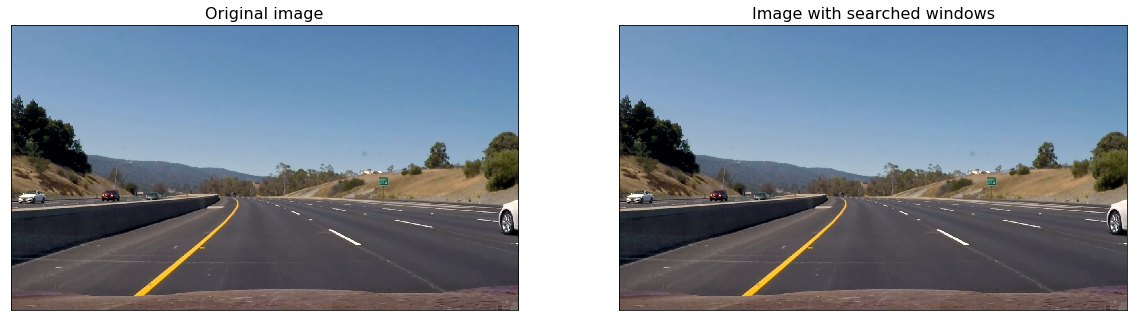

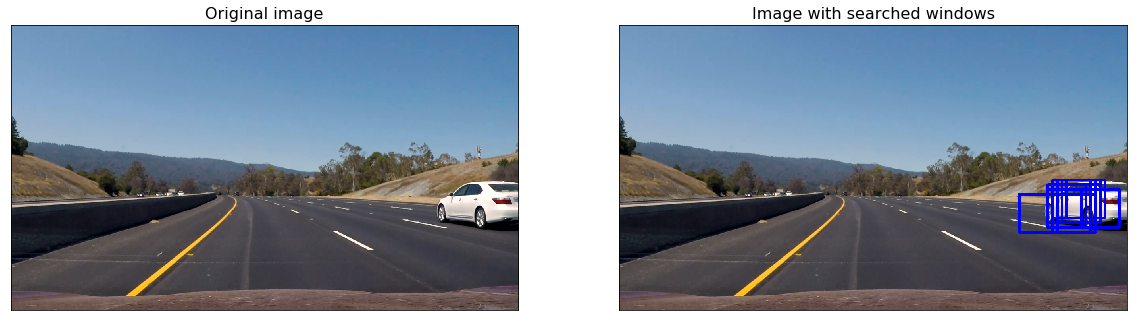

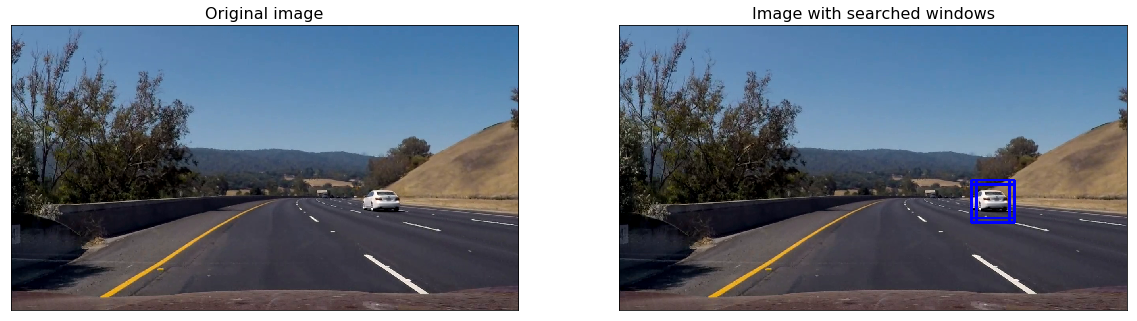

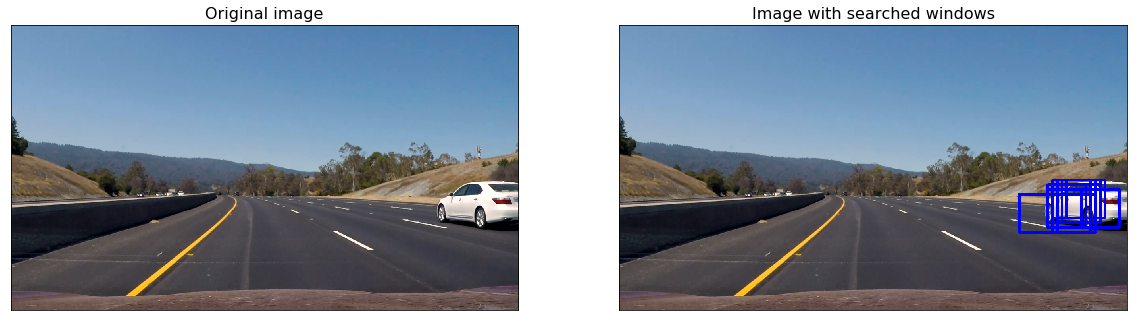

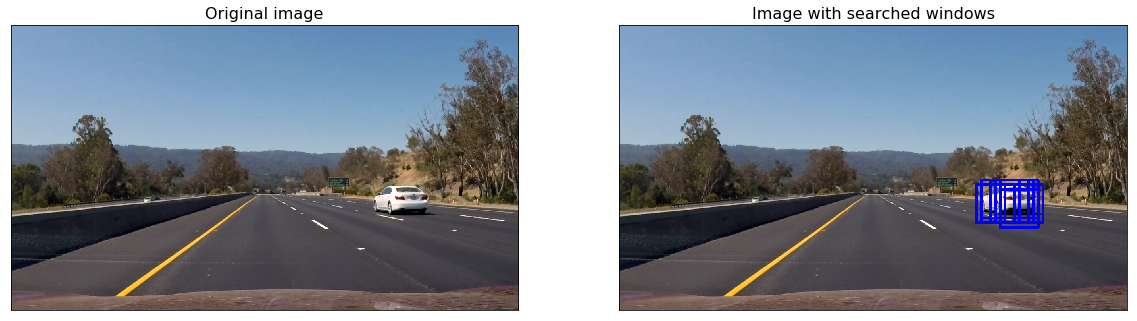

In [16]:
for _ in range(6):
    t = np.random.randint(0, 50)
    frame = VideoFileClip('project_video.mp4').get_frame(t)
    demo_search_windows(frame, lsvc, scaler)


### Video Implementation

#### 1. Provide a link to your final video output.  Your pipeline should perform reasonably well on the entire project video (somewhat wobbly or unstable bounding boxes are ok as long as you are identifying the vehicles most of the time with minimal false positives.)
Here's a [link to my video result](test_videos_output/project_video.mp4)

#### 2. Describe how (and identify where in your code) you implemented some kind of filter for false positives and some method for combining overlapping bounding boxes.


I recorded the positions of positive detections in each frame of the video.  From the positive detections I created a heatmap and then thresholded that map to identify vehicle positions.  I then used `scipy.ndimage.measurements.label()` to identify individual blobs in the heatmap.  I then assumed each blob corresponded to a vehicle.  I constructed bounding boxes to cover the area of each blob detected.  

Here's an example result showing the heatmap from a series of frames of video, the result of `scipy.ndimage.measurements.label()` and the bounding boxes then overlaid on the last frame of video:

#### Here are six frames and their corresponding heatmaps:

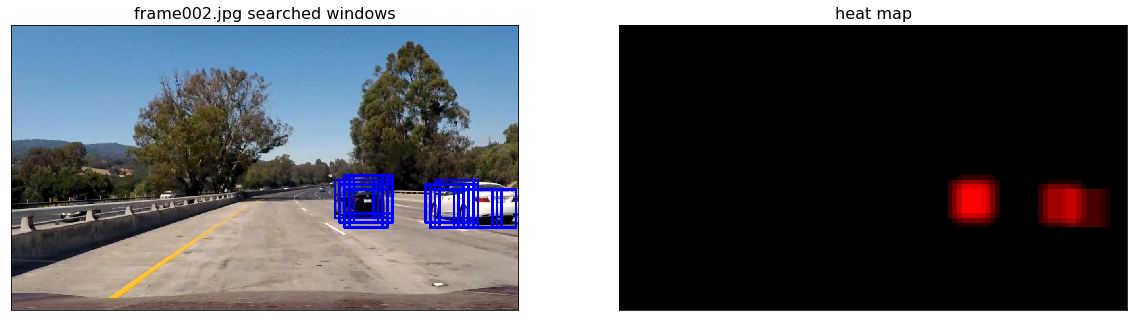

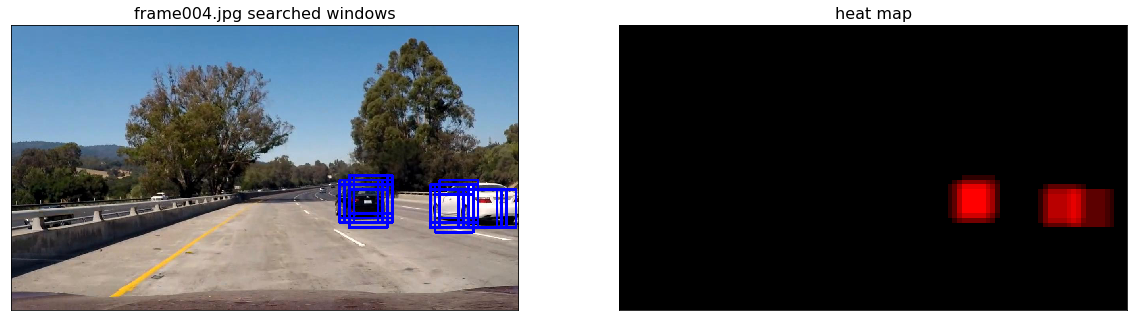

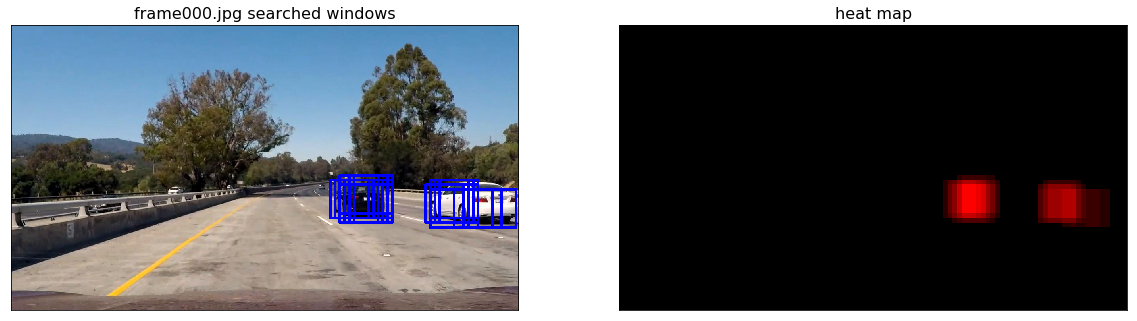

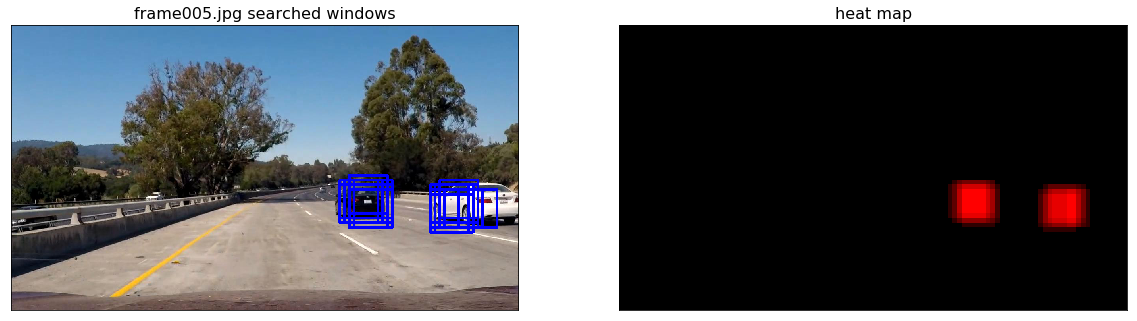

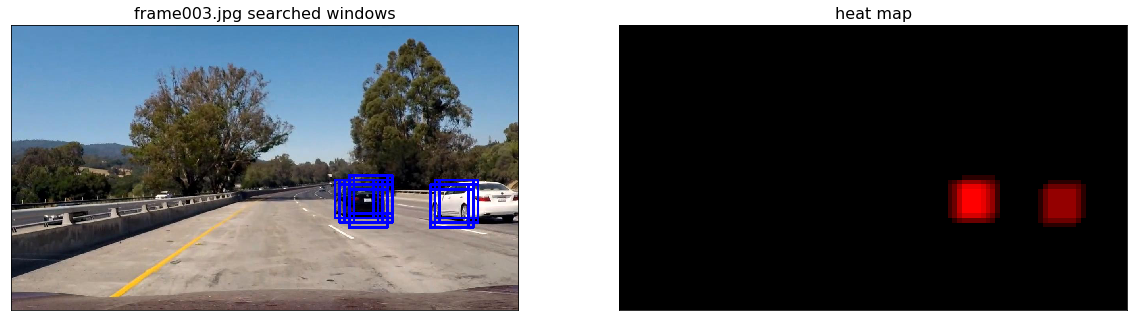

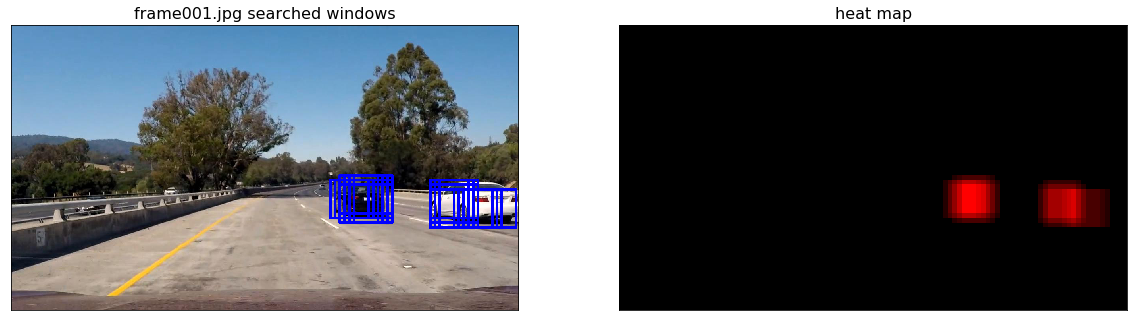

In [17]:
image_series = glob.glob('video_frames/*.jpg')
hot_windows_all = []
frame_img = None
for f in image_series:
    fname = os.path.split(f)[1]
    frame_img = mpimg.imread(f)
    hot_windows= search_windows(frame_img, lsvc, scaler, hist_bins=48,
                                scales = [1.5],
                                y_start_stop=[380, 680],
                                window=64)
    hot_windows_all.extend(hot_windows)
    hot_windows_img = draw_boxes(frame_img, hot_windows)
    heatmap = get_heatmap(hot_windows, image_size=(720, 1280), threshold=1)
    heatmap_img = np.dstack((heatmap / np.max(heatmap) * 255, 
                             np.zeros_like(heatmap), 
                             np.zeros_like(heatmap))).astype(np.uint8)
    img_list = [(fname + ' searched windows', hot_windows_img),
                ('heat map', heatmap_img)]
    plot_images(img_list)

#### Here is the output of scipy.ndimage.measurements.label() on the integrated heatmap from all six frames, with threshold=10:

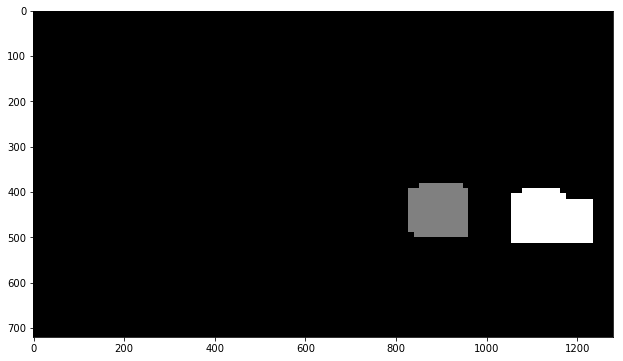

In [18]:
heatmap = get_heatmap(hot_windows_all, (720, 1280), threshold=6)
labeled_array, n_cars = label(heatmap)
plt.figure(figsize=(15, 6))
plt.imshow(labeled_array, cmap='gray')

#### Here the resulting bounding boxes are drawn onto the last frame in the series:

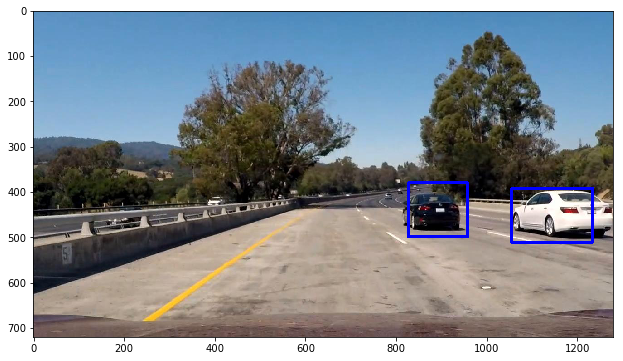

In [19]:
bboxes = get_bounding_boxes(heatmap)
bboxes_img = draw_boxes(frame_img, bboxes)
plt.figure(figsize=(15, 6))
plt.imshow(bboxes_img)

### Apply to video
#### Combined with Advanced Lane Finding project

In [20]:
cali_file = 'camera_cal.p'
camera = Camera.from_cal_file(cali_file)

In [21]:
# helper functions for combining lane finding and embed sub-images

def get_combined_threshold(image):   
        # V channel < 105 is considered as white
        v_thresh_binary = color_thresholded(image, cvt_from='RGB', cvt_to='YUV', channel='V', 
                                            thresh_min=0, thresh_max=104)
        # Y channel >= 205 is considered as yellow
        y_thresh_binary = color_thresholded(image, cvt_from='RGB', cvt_to='YUV', channel='Y',
                                            thresh_min=205, thresh_max=255) 
        c_thresh_binary = np.zeros_like(v_thresh_binary)
        c_thresh_binary[(v_thresh_binary == 1) | (y_thresh_binary == 1)] = 1
        sx_thresh_binary = abs_sobel_thresh(image, orient='x', thresh_min=40, thresh_max=100)
        
        # combine color threshold and sobel-x threshold
        combined_binary = np.zeros_like(sx_thresh_binary)
        combined_binary[(c_thresh_binary == 1) | (sx_thresh_binary == 1)] = 1
        
        return combined_binary
    

def get_lane_marking(image, warped):    
    global reset_line_base, left_line, right_line
    if reset_line_base:
        left_line, right_line = get_lines(warped)
        reset_line_base = False
    else:
        left_line.update(warped)
        right_line.update(warped)
    
    ploty = np.linspace(0, 719, 720)
    left_fitx = left_line.get_fitx(ploty)
    right_fitx = right_line.get_fitx(ploty)
    # create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    # recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0, 90, 0))
    
    newwarp = camera.inverse_perspective_transform(color_warp)
    
    # calculate the average curvature (in meter)
    font = cv2.FONT_HERSHEY_SIMPLEX
    avg_curverad = (left_line.curverad + right_line.curverad) / 2
    cv2.putText(newwarp,'Curvature Radius = {:.2f}(m)'.format(avg_curverad), 
                (20,250), font, 1, (255,255,255), 2, cv2.LINE_AA)
     
    # calculate off-center distance (in meter)
    dist = (left_line.dist2center + right_line.dist2center) / 2
    if not np.isclose(dist, 0.):
        side = 'right' if dist < 0 else 'left'
    cv2.putText(newwarp,'Vehicle Offset = {:.2f}m {}'.format(abs(dist), side), 
                (20,300), font, 1, (255,255,255), 2, cv2.LINE_AA)
    
    return newwarp


# combined threshold, warp, hot_win_img, heatmap
def embed_images(image, image_list, boxes):
    image_ = np.copy(image)
    for img, box in zip(image_list, boxes):
        x0, y0 = box[0]
        x1, y1 = box[1]
        image_[y0:y1, x0:x1] = cv2.resize(img, (x1-x0, y1-y0))
        
    return image_

In [22]:
que_size = 5
hot_windows_que = deque(maxlen=que_size)
image_shape = (720, 1280)
sub_images_boxes = [((0, 0), (320, 200)), ((320, 0), (640, 200)),
                    ((640, 0), (960, 200)), ((960, 0), (1280, 200))]
heatmap_thresh = 7

def process_image(image):
    ### get lane marking image
    undist = camera.undistort(image)
    # combined color threshold and sobel-x threshold
    combined_thresh = get_combined_threshold(undist)
    thresh_color = np.dstack((combined_thresh, combined_thresh, combined_thresh)) * 255
    # perspective transform the combined threshold
    warp = camera.perspective_transform(combined_thresh)
    warp_color = np.dstack((warp, warp, warp)) * 255
    lane_marking = get_lane_marking(image, warp)
    
    ### get bounding boxes image
    # windows that classified as car images
    hot_windows = search_windows(image, lsvc, scaler, scales, hist_bins=48, 
                                 y_start_stop=y_start_stop)
    hot_windows_img = draw_boxes(image, hot_windows)
    hot_windows_que.append(hot_windows)
    hot_windows = list(chain(*hot_windows_que))  
    
    if len(hot_windows_que) < que_size:
        threshold = len(hot_windows_que) * 2 - 1
    else:
        threshold = heatmap_thresh
        
    heatmap = get_heatmap(hot_windows, image_shape, threshold=threshold)
    heatmap_img = np.dstack((heatmap / np.max(heatmap) * 255, 
                             np.zeros_like(heatmap), 
                             np.zeros_like(heatmap))).astype(np.uint8)
    bboxes = get_bounding_boxes(heatmap)
    bboxes_img = draw_boxes(image, bboxes)

    ### combine lane marking and bounding box
    draw_img = cv2.addWeighted(bboxes_img, 1, lane_marking, 1, 0)

    ### embed sub-images: combined-threshold, warp, hot-windows, heatmap
    image_list = [thresh_color, warp_color, hot_windows_img, heatmap_img]
    draw_img = embed_images(draw_img, image_list, sub_images_boxes)
    
    return draw_img

In [23]:
reset_line_base = True
left_line, right_line = None, None

white_output = 'test_videos_output/project_video.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image)
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/project_video.mp4
[MoviePy] Writing video test_videos_output/project_video.mp4


100%|█████████▉| 1260/1261 [35:42<00:01,  1.69s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/project_video.mp4 

CPU times: user 40min 39s, sys: 2.8 s, total: 40min 42s
Wall time: 35min 43s


In [24]:
HTML("""
<video width="800" height="480" controls>
  <source src="{0}">
</video>
""".format(white_output))